# Analysis
In this notebook, we conduct a number of analyses, including:
- observed vs. expected heterozygosity
- site frequency spectrum

In [2]:
import allel
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle as pkl
import json
import umap

# for the maps
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

In [3]:
#  file paths
vcf_path = 'data/variants.vcf.gz'
metadata = pd.read_csv("data/fixed.csv")

Create genotype matrices

In [4]:
# this reads the vcf file into a callset
callset = allel.read_vcf(vcf_path)

# this makes the genotype allele!
gt = allel.GenotypeArray(callset['calldata/GT'])
variants = pd.DataFrame({
    'CHROM': callset['variants/CHROM'],
    'POS': callset['variants/POS'],
    'ID': callset['variants/ID'],
    'REF': callset['variants/REF'],
    'ALT': [a[0] if isinstance(a, (list, tuple)) and len(a) > 0 else None for a in callset['variants/ALT']]
})

geno = gt.to_n_alt()

/Users/skylarwalters/miniconda3/envs/cs2370/lib/python3.13/site-packages/allel/io/vcf_read.py:1732: UserWarning: invalid INFO header: '##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">\n'
  warnings.warn('invalid INFO header: %r' % header)


We also need to load the genotype matrices for the llatzer and mary magdalen datasets

In [5]:
llatzer_inds = [1, 2, 3, 4, 5, 6, 9, 10, 11]
mary_inds = [16, 17, 18, 21, 22]

llatzer = gt[:, llatzer_inds]
print(f'Llatzer size: {llatzer.shape}')
magdalen = gt[:, mary_inds]
print(f'Magdalen size: {magdalen.shape}')

Llatzer size: (551, 9, 2)
Magdalen size: (551, 5, 2)


epic! Now, we are ready for
## Heterozygosity calculations

First, we need to derive the observed heterozygosity.

In [6]:
is_het = geno == 1
obs_heterozygosity_mat = is_het.mean(axis=1)

# find mean to get the heterozygosity
obs_heterozygosity = obs_heterozygosity_mat.mean()
print(f'Observed heterozygosity: {obs_heterozygosity}')

Observed heterozygosity: 0.1667324232620532


Now, we are going to find the expected heterozygosity. Recall H_e = 2pq, where:

- p: reference allele freq
- q: 1-p


In order to do this, we need to
1. find the total allele count for each variant
2. Note that the frist col of the allele is the ref seq; the second is the alternate allele. 
3. Derive q and p from the alt and ref allele cts!
4. Plug into 2pq


In [7]:
# step 1
allele_ct = gt.count_alleles()

# step 2/3
# q from the alt allele seciton
q = allele_ct[:, 1] / allele_ct.sum(axis=1)
p = 1 - q

# step 4
exp_heterozygosity_tot = 2 * p * q
exp_heterozygosity = np.nanmean(exp_heterozygosity_tot)

In [8]:
print(f'Expected heterozygosity: {exp_heterozygosity}')
print(f'Observed heterozygosity: {obs_heterozygosity}')

Expected heterozygosity: 0.3232715766351734
Observed heterozygosity: 0.1667324232620532


#### Now, let's look at per sample heterozygosity.

In [9]:
p = allele_ct[:, 0] / allele_ct.sum(axis=1)
q = allele_ct[:, 1] / allele_ct.sum(axis=1)
He_per_snp = 2 * p * q 

print(f'expected count per snp: {He_per_snp}')

expected count per snp: [0.         0.32       0.24489796 0.18       0.         0.375
 0.         0.46875    0.32       0.27777778 0.         0.375
 0.27777778 0.27777778 0.         0.27777778 0.27777778 0.
 0.32       0.16       0.375      0.24489796 0.375      0.
 0.21875    0.32       0.24489796 0.24489796 0.32       0.32
 0.40816327 0.46875    0.24489796 0.375      0.         0.27777778
 0.44444444 0.5        0.375      0.19753086 0.32       0.
 0.48       0.48       0.27777778 0.32       0.48       0.
 0.44444444 0.40816327 0.21875    0.48       0.375      0.48
 0.48979592 0.375      0.44444444 0.46875    0.375      0.32
 0.40816327 0.24489796 0.24489796 0.         0.27777778 0.375
 0.44444444 0.375      0.32       0.5        0.32       0.375
 0.         0.         0.27777778 0.5        0.         0.375
 0.         0.24489796 0.32       0.27777778 0.32       0.16
 0.32       0.24489796 0.24489796 0.24489796 0.5        0.375
 0.48       0.44444444 0.19753086 0.48       0.24489796 0

Apply this to the full sample set

In [10]:
Ho_per_sample = is_het.mean(axis=0)
print(f'Observed heterozygosity: {Ho_per_sample}')

Observed heterozygosity: [0.         0.16515426 0.19963702 0.1415608  0.30671506 0.31397459
 0.01633394 0.25589837 0.1814882  0.11433757 0.353902   0.02903811
 0.0199637  0.06170599 0.27767695 0.17241379 0.19600726 0.25408348
 0.07985481 0.21960073 0.06533575 0.07622505 0.33393829]


In [11]:
He_per_sample = []

for i in range(geno.shape[1]): 
    
    # mask missing samples
    valid = ~np.isnan(geno[:, i]) 
    He_sample = np.nanmean(He_per_snp[valid])
    # add for sample
    He_per_sample.append(He_sample)

He_per_sample = np.array(He_per_sample)

for s, he in zip(metadata['Sample_Name'], He_per_sample):
    print(s, he)

KirkHill_lep_udg 0.3149486554508031
CHRY023_ML9_lep_udg 0.3149486554508031
UF803_lep_udg 0.3149486554508031
UF800_lep_udg 0.3149486554508031
UF25_lep_udg 0.3149486554508031
UF21_lep_udg 0.3149486554508031
UF11_lep_udg 0.3149486554508031
UF8_lep_udg 0.3149486554508031
COR_XVIII_lep_udg 0.3149486554508031
UF800_lep_udg 0.3149486554508031
UF703_lep_udg 0.3149486554508031
UF700_lep_udg 0.3149486554508031
MMW_H50_1 0.3149486554508031
MMW_H80_1 0.3149486554508031
Body 188 0.3149486554508031
SK11 0.3149486554508031
T18 0.3149486554508031
GC96 0.3149486554508031
SK2 0.3149486554508031
3077 0.3149486554508031
Jorgen_625 0.3149486554508031
SK14 0.3149486554508031
SK8 0.3149486554508031


In [12]:
het_data = np.array([metadata['Sample_Name'], metadata["Age"], He_per_sample, Ho_per_sample]).T

In [13]:
heterozygosity_df = pd.DataFrame(
    data=het_data,
    columns=["Sample", "Age", "He", "Ho"]
)
heterozygosity_df

,Sample,Age,He,Ho
0,KirkHill_lep_udg,1092-00-00,0.314949,0.0
1,CHRY023_ML9_lep_udg,1098-00-00,0.314949,0.165154
2,UF803_lep_udg,1150-00-00,0.314949,0.199637
3,UF800_lep_udg,1090-00-00,0.314949,0.141561
4,UF25_lep_udg,1444-00-00,0.314949,0.306715
5,UF21_lep_udg,1521-00-00,0.314949,0.313975
6,UF11_lep_udg,1700-00-00,0.314949,0.016334
7,UF8_lep_udg,1500-00-00,0.314949,0.255898
8,COR_XVIII_lep_udg,1250-00-00,0.314949,0.181488
9,UF800_lep_udg,1090-00-00,0.314949,0.114338


## Site frequency spectrum

Yay! Now, we can create the site freq. spectrum. This involves: 
1. Loading gt arr
2. counting alleles for each snp (derived)
3. count freqs into bins
4. plot!

In [14]:
# step 2
alternatives = allele_ct[:, 1]
# step 3
sfs = np.bincount(alternatives, minlength=gt.n_samples + 1)
# use min len so no error

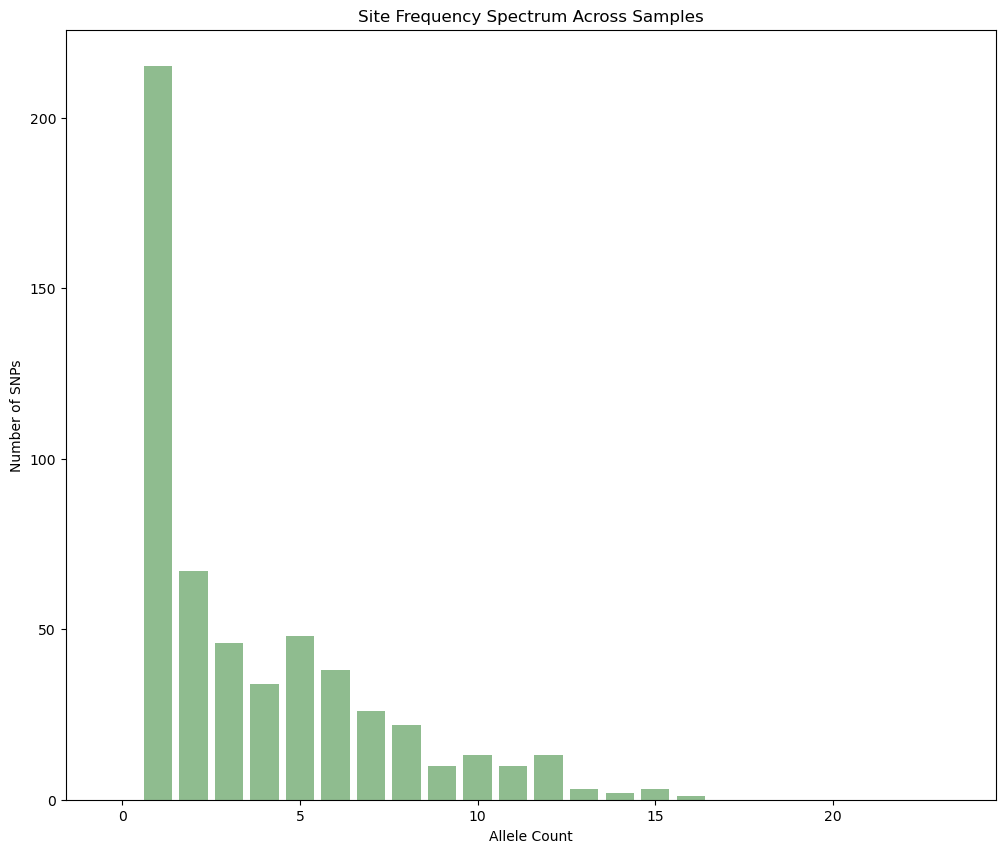

In [15]:
plt.figure(figsize=(12,10))
plt.bar(
    np.arange(len(sfs)), 
    sfs,
    color='darkseagreen')
plt.title("Site Frequency Spectrum Across Samples")
plt.xlabel('Allele Count')
plt.ylabel('Number of SNPs')
plt.savefig("site_frequency_spectrum.png")
plt.show()

In [20]:
mutant_prop = geno.mean(axis=1)

# add to variants table
variants['mutant_prop'] = mutant_prop

# get 5 sites with highest mutant proportion
top15 = variants.nlargest(15, 'mutant_prop')

top15

,CHROM,POS,ID,REF,ALT,mutant_prop
181,CP029543.1,1308835,.,A,None,0.695652
180,CP029543.1,1308834,.,T,None,0.652174
182,CP029543.1,1308856,.,T,None,0.652174
239,CP029543.1,1309990,.,C,None,0.652174
187,CP029543.1,1308947,.,T,None,0.608696
220,CP029543.1,1309685,.,C,None,0.608696
236,CP029543.1,1309961,.,A,None,0.608696
326,CP029543.1,1313104,.,A,None,0.608696
217,CP029543.1,1309640,.,T,None,0.565217
234,CP029543.1,1309937,.,T,None,0.565217
